## Short example of Model fitting

Here we fit a MRI-style model to some simulated data.

The model is: $\textrm{Signal} = M_0\exp\left[-R_2\textrm{TE}\right]\left(1-\exp\left[-R_1\textrm{TI}\right]\right)$ 

The parameters that we will be fitting are $(M_0,R_1,R_2)$. 

Basic imports:


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In this section:

- defining a numpy array
- double list comprehension


In [3]:
TEs = np.array([10,40,50,60,80]) # TE values in ms
TRs = np.array([.8,1,1.5,2])     # TR in seconds (I know this is bad)

# All combinations of TEs/TRs
comb    = np.array([(x,y) for x in TEs for y in TRs])
TEs,TRs = comb[:,0],comb[:,1]



Now we define our forward model

In this section:

- inline function definition
- random number generation

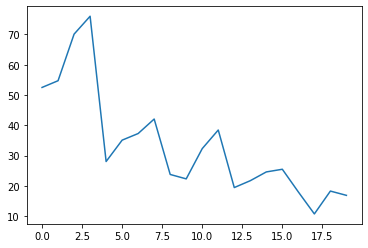

In [4]:

# function for our model
def forward(p):
    M0,R1,R2 = p
    return M0*np.exp(-R2*TEs)*(1-np.exp(-R1*TRs))

# simulate data using model 
true_p    = [100,1/.8,1/50]   # M0, R1=1/T1,R2=1/T2
data      = forward(true_p)
snr       = 50
noise_std = true_p[0]/snr
noise     = np.random.randn(data.size)*noise_std
data      = data + noise

# quick plot of the data
plt.figure()
plt.plot(data)


Now we have the data and our forward model we are almost ready to begin fitting.

We need a cost function to optimise. We will use mean squared error. 

In this section:

- '**' operation
- np.mean

In [5]:
# cost function is mean square error divided by 2
def cf(p):
    pred = forward(p)
    return np.mean((pred-data)**2)/2.0


Now we can set up our optimisation.

In this section:

- scipy minimize
- dictionary
- keyword arguments


In [10]:
# get ready to minimize
p0 = [200,1/1,1/70]  # some random initial guess
method = 'powell' # pick a method. scipy has loads!


kw_args = {'x0':p0,'method':method}
result  = minimize(cf,**kw_args)



Plot the data with the model prediction.

In this section

- printing
- text formatting


fitted = [1.02562035e+02 1.16194491e+00 1.98071179e-02]
true   = [100, 1.25, 0.02]


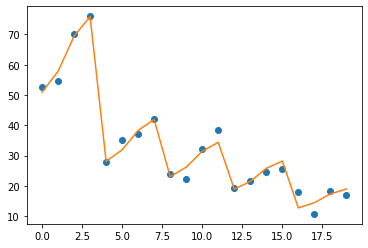

In [11]:
plt.figure()
plt.plot(data,'o')
plt.plot(forward(result.x))
print('fitted = {}'.format(result.x))
print('true   = {}'.format(true_p))


## Optional: use gradients and hessians to help with the optimisation

In this example the forward model is simple enough that calculating the derivatives of the cost function is relatively easy to do analytically. Below is an example of how you could define these and use them in the fitting




In [12]:

# gradient of the forward model
def forward_deriv(p):
    M0,R1,R2 = p
    E1,E2    = np.exp(-R1*TRs),np.exp(-R2*TEs)
    dE1      = -TRs*E1
    dE2      = -TEs*E2
    
    # f = M0*E2*(1-E1)
    dfdM0 = E2*(1-E1)
    dfdR1 = M0*E2*(-dE1)
    dfdR2 = M0*dE2*(1-E1)
    return np.array([dfdM0,dfdR1,dfdR2])

# hessian of the forward model
def forward_deriv2(p):
    M0,R1,R2 = p
    E1,E2    = np.exp(-R1*TRs),np.exp(-R2*TEs)
    dE1      = -TRs*E1
    dE2      = -TEs*E2
    ddE1     = (TRs**2)*E1
    ddE2     = (TEs**2)*E2
    
    dfdM0dM0 = np.zeros(E1.shape)
    dfdM0dR1 = E2*(-dE1)
    dfdM0dR2 = dE2*(1-E1)

    dfdR1dM0 = E2*(-dE1)
    dfdR1dR1 = M0*E2*(-ddE1)
    dfdR1dR2 = M0*(dE2)*(-dE1)
 
    dfdR2dM0 = dE2*(1-E1)
    dfdR2dR1 = M0*dE2*(-dE1)
    dfdR2dR2 = M0*ddE2*(1-E1)

    return np.array([[dfdM0dM0,dfdM0dR1,dfdM0dR2],
                     [dfdR1dM0,dfdR1dR1,dfdR1dR2],
                     [dfdR2dM0,dfdR2dR1,dfdR2dR2]])


# cost function is mean square error divided by 2
def cf(p):
    pred = forward(p)
    return np.mean((pred-data)**2)/2.0

def cf_grad(p):
    pred  = forward(p)
    deriv = forward_deriv(p)
    return np.mean( deriv * (pred-data)[None,:],axis=1)

def cf_hess(p):
    pred   = forward(p)
    deriv  = forward_deriv(p)
    deriv2 = forward_deriv2(p)
    
    H = np.zeros((len(p),len(p)))
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            H[i,j] = np.mean(deriv2[i,j]*(pred-data) + deriv[i]*deriv[j])
    return H
    




fitted = [1.02576306e+02 1.16153921e+00 1.98044006e-02]
true   = [100, 1.25, 0.02]


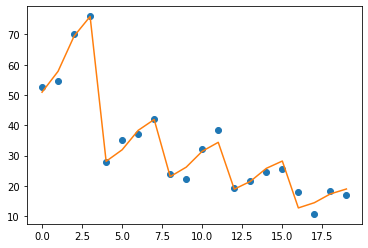

In [13]:


# get ready to minimize
p0 = [200,1/1,1/70] # some random guess
method = 'trust-ncg'

kw_args = {'x0':p0,'method':method,'jac':cf_grad,'hess':cf_hess}

result = minimize(cf,**kw_args)


plt.figure()
plt.plot(data,'o')
plt.plot(forward(result.x))
print('fitted = {}'.format(result.x))
print('true   = {}'.format(true_p))




## The end.